## Live plotting for LiberTEM UDFs

This example demonstrates the live plotting feature of LiberTEM that is introduced in release 0.7.0. It can update a plot with new results while LiberTEM processing is running.

This notebook requires additional packages `bqplot`, `bqplot_image_gl` and `ipywidgets`. See also https://ipywidgets.readthedocs.io/en/stable/user_install.html#installing-in-classic-jupyter-notebook
in case the plots don't show.

In [1]:
%matplotlib nbagg

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors
import ipywidgets
import IPython
import numpy as np

import libertem.api as lt
from libertem.udf import UDF
from libertem.udf.raw import PickUDF
from libertem.viz.mpl import MPLLive2DPlot
from libertem.viz.bqp import BQLive2DPlot

### Plot classes

Currently, LiberTEM implements three back-ends for live plotting:

- `libertem.viz.mpl.MPLLive2DPlot` with a `matplotlib` back-end. It is the default since `matplotlib` is the most popular and mature plotting package for Python. It requires about 100-200 ms to display or update a plot, which only allows a few updates per second.
- `libertem.viz.bqp.BQLive2DPlot` with a `bqplot_image_gl` back-end. It is much faster than `matplotlib` and can easily keep up with the full update rate of LiberTEM for a smoother and more responsive display.
- `libertem.viz.gms.GMSLive2DPlot` for plotting within Digital Micrograph, Gatan Microscopy Suite. This only works using the Python scripting of recent GMS releases and is not demonstrated here.

Additional plotting back-ends can be implemented by deriving from `libertem.viz.base.Live2DPlot`.

Here we change the default class for live plotting to `BQLive2DPlot` and then change it back right away by assigning to the `plot_class` property of the LiberTEM `Context` object.

In [3]:
# We set the Context to use BQLive2DPlot for live plotting
ctx = lt.Context(plot_class=BQLive2DPlot)

# We change it right back to the default MPLLive2DPlot
ctx.plot_class = MPLLive2DPlot

In [4]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")
ds = ctx.load("auto", path=os.path.join(data_base_path, "20200518 165148/default.hdr"))

# This internal method is used here to artificially create more partitions than necessary
# for better demonstration of live plotting on machines with few cores.
# This reduces performance, should NOT be used in production and can change without
# notice in future releases.
ds.set_num_cores(32)

### Demo UDFs

We implement three simple user-defined functions (UDFs) to demonstrate the various features and options for live plotting. They calculate a map of the navigation space with sum and maximum, a map of the signal space with sum and maximum, and a global maximum.

See https://libertem.github.io/LiberTEM/udf.html for more information on UDFs.

In [5]:
class DemoNavUDF(UDF):
    def get_result_buffers(self):
        return {
            'nav_sum': self.buffer(kind='nav', dtype='float32'),
            'nav_max': self.buffer(kind='nav', dtype='float32'),
        }
    
    def process_frame(self, frame):
        self.results.nav_sum[:] = np.sum(frame)
        self.results.nav_max[:] = np.max(frame)
                

class DemoSigUDF(UDF):
    def get_result_buffers(self):
        return {
            'sig_sum': self.buffer(kind='sig', dtype='float32'),
            'sig_max': self.buffer(kind='sig', dtype='float32'),
        }
    
    def process_frame(self, frame):
        self.results.sig_sum += frame
        np.maximum(self.results.sig_max, frame, out=self.results.sig_max)
        
    def merge(self, dest, src):
        dest.sig_sum += src.sig_sum
        np.maximum(dest.sig_max, src.sig_max, out=dest.sig_max)
        

class DemoSingleUDF(UDF):
    def get_result_buffers(self):
        return {
            'maximum': self.buffer(kind='single', dtype='float32'),
        }
    
    def process_frame(self, frame):
        self.results.maximum[:] = np.maximum(self.results.maximum, np.max(frame))
        
    def merge(self, dest, src):
        dest.maximum[:] = np.maximum(dest.maximum, src.maximum)

The UDFs are instantiated and stored in a list for subsequent use.

In [6]:
udfs = [DemoNavUDF(), DemoSigUDF(), DemoSingleUDF()]

### Plot all plottable channels

Note how `Context.run_udf()` can execute several UDFs in one pass since release 0.7.0 by passing a list or tuple of UDFs.

By setting `plots=True` you can plot all channels that have a 2D shape after applying `np.squeeze`. The `DemoSingleUDF` is not plotted since its only channel `maximum` is a single value. This triggers a warning.

/home/alex/source/LiberTEM/src/libertem/api.py:863: UserWarning: No plottable channels found for UDF #2: DemoSingleUDF, not plotting.
  warnings.warn(


<IPython.core.display.Javascript object>


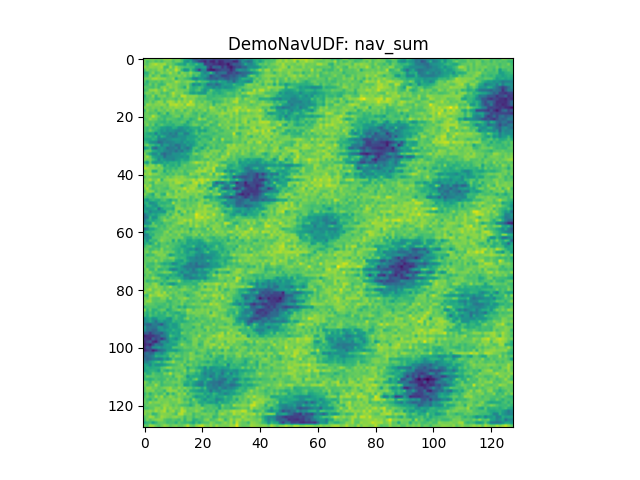

<IPython.core.display.Javascript object>


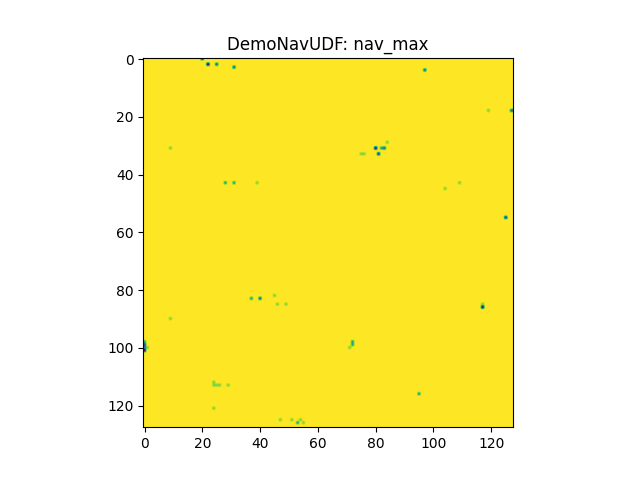

<IPython.core.display.Javascript object>


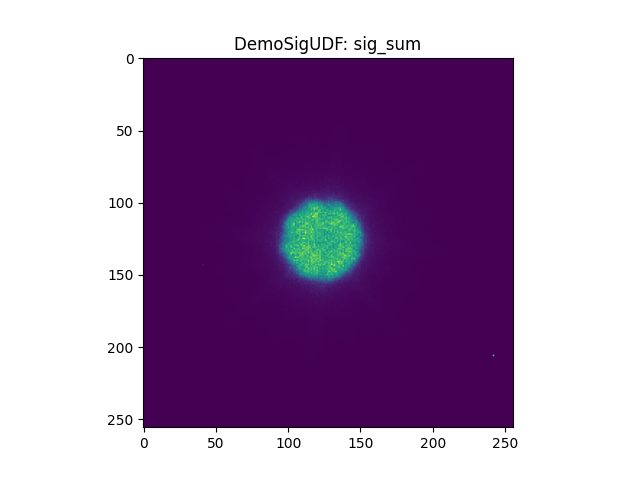

<IPython.core.display.Javascript object>


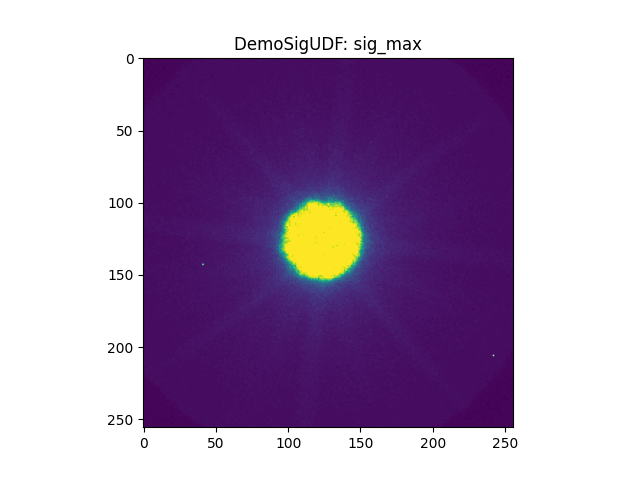

In [7]:
res = ctx.run_udf(dataset=ds, udf=udfs, plots=True)

### Select specific channels

We can specify which channels should be plotted by passing a nested list with channel names for each of the UDFs as the `plots` parameter.

<IPython.core.display.Javascript object>


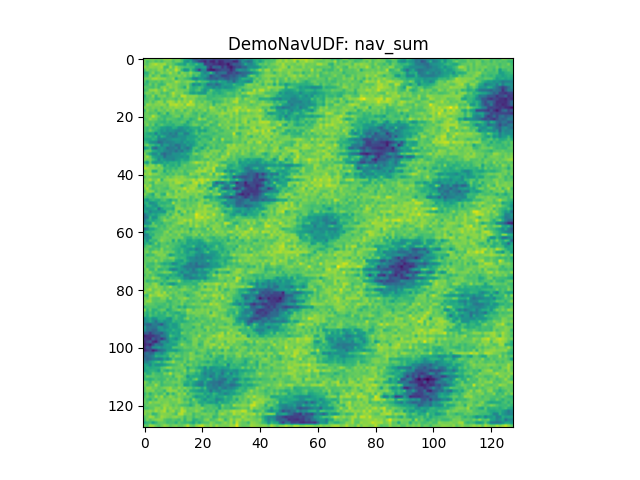

<IPython.core.display.Javascript object>


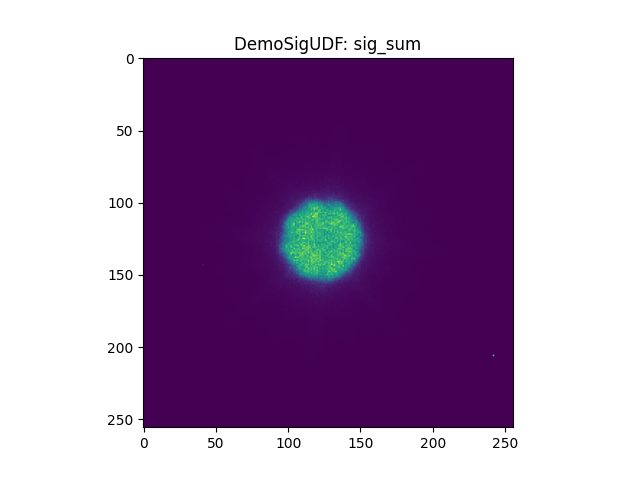

<IPython.core.display.Javascript object>


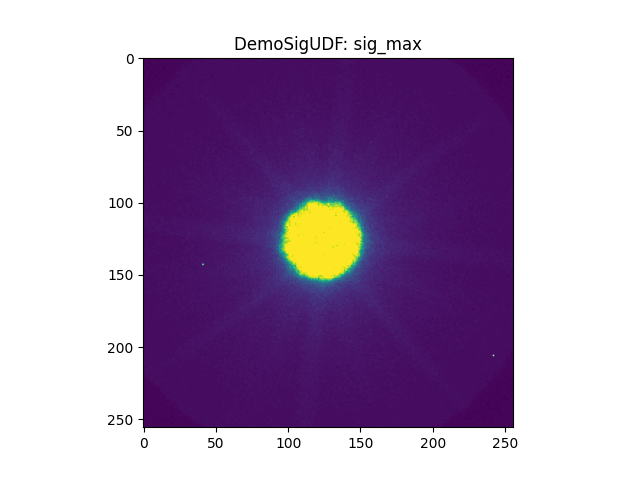

In [8]:
res = ctx.run_udf(dataset=ds, udf=udfs, plots=[['nav_sum'], ['sig_sum', 'sig_max']])

### Apply a function to a channel

Together with the channel name we can specify a function to apply to the channel before plotting. This can plot a channel that doesn't work with default plotting by transforming it into something plottable. Here we demonstrate this with the single-valued `maximum` channel.

The same channel can be plotted several times with a different function. This is particularly useful to plot the absolute value and the phase angle for complex numbers: `('chan', np.abs)`, `('chan', np.angle)`. Here we demonstrate this with thresholding.

In [9]:
# Just some thresholding for demonstration
def larger(x):
    return x > 9.3e4

def smaller(x):
    return x < 9e4

<IPython.core.display.Javascript object>


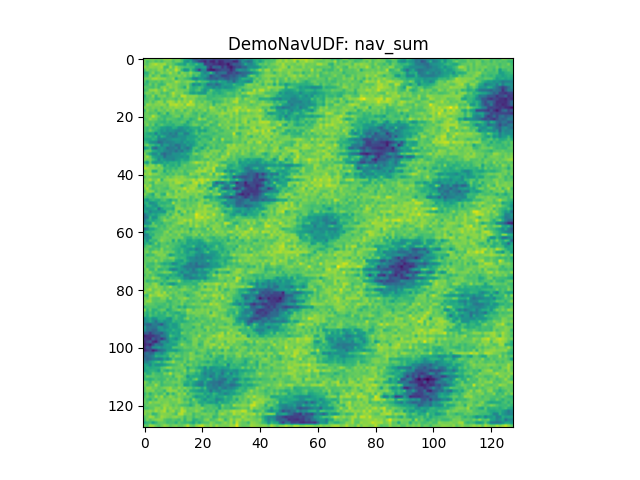

<IPython.core.display.Javascript object>


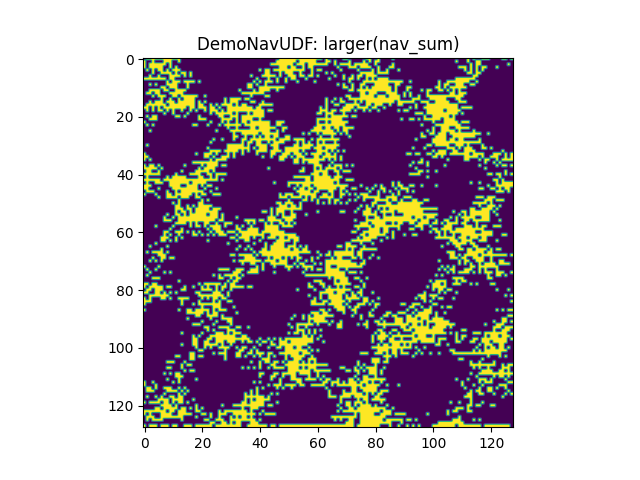

<IPython.core.display.Javascript object>


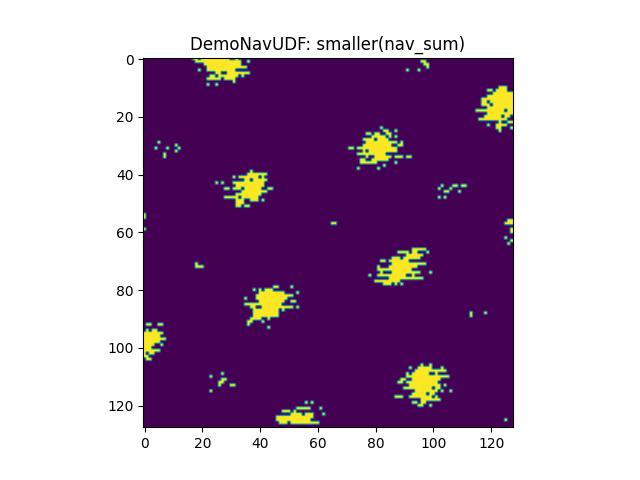

<IPython.core.display.Javascript object>


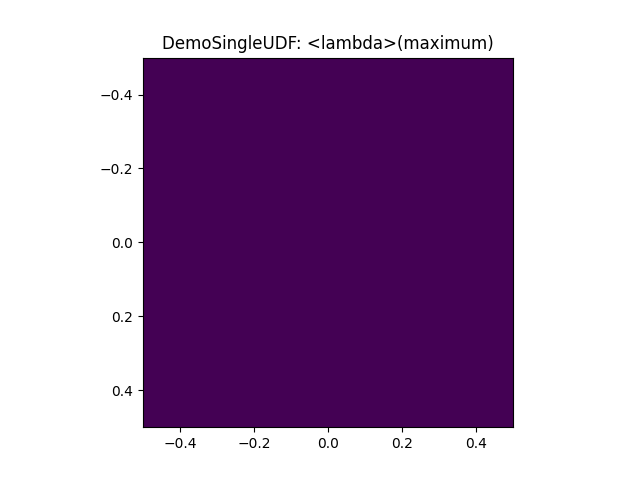

In [10]:
plot_list=[
    ['nav_sum', ('nav_sum', larger), ('nav_sum', smaller)],
    [],
    [('maximum', lambda x: x.reshape((1, 1)))]
]

res = ctx.run_udf(dataset=ds, udf=udfs, plots=plot_list)

### Custom plot setup

If we want to have more control over the plots and their layout, we can instantiate plots separately and pass them to `run_udf()` via the `plots` parameter. This also allows to set additional parameters such as the title. Note how `MPLLive2DPlot` passes additional keyword arguments, in this case the color map `cmap` and the `norm`, to `matplotlib.pyplot.imshow`.

The UDF passed to the live plot via the `udf` parameter has to be the same instance that is later run in `run_udf()` to ensure that results are assigned to the correct plot.

In [11]:
live_plot = MPLLive2DPlot(
    dataset=ds,
    udf=udfs[1],
    # We add 1 for log scale display since there are zeros in the result
    channel=('sig_sum', lambda x: 1 + x),
    title="1 + x, log scaled display",
    # These parameters are passed to imshow()
    cmap='inferno',
    norm=matplotlib.colors.LogNorm()
)

<IPython.core.display.Javascript object>


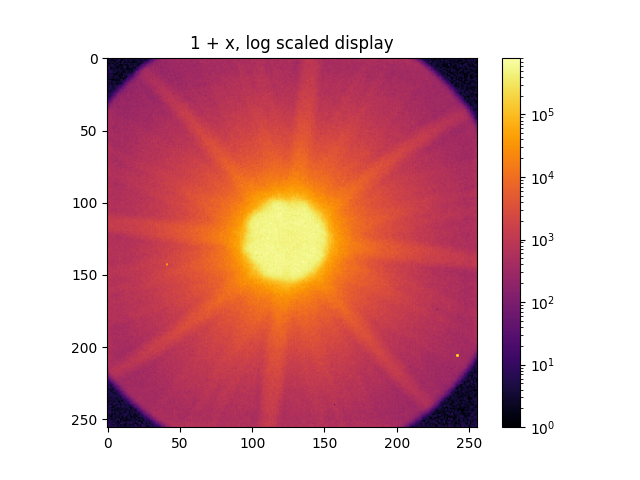

In [12]:
live_plot.display()
# We can access and modify the matplotlib objects, in this case to add a color bar
live_plot.fig.colorbar(live_plot.im_obj)

In [13]:
# Run the UDF, showing live results in the plot above
res = ctx.run_udf(dataset=ds, udf=udfs, plots=[live_plot])

### Gridded display

Here we use `bqplot` and arrange the plots in a grid. The same method can also be used with `MPLLive2DPlot` if the output method of `matplotlib` is  switched to use `ipywidgets`. Just install `ipympl`, replace `%matplotlib nbagg` at the top of the notebook with `%matplotlib widget` and restart the kernel.

Note that at the time of writing this notebook, a `MPLLive2DPlot` combined with display method "widget" will only update live if it is created and displayed separately, not if this is done automatically in `run_udf()` .

In [14]:
# NBVAL_IGNORE_OUTPUT
# (output is ignored in nbval run because it somehow doesn't play nice with bqplot)

live_plots = [
    BQLive2DPlot(dataset=ds, udf=udfs[0], channel='nav_sum'),
    BQLive2DPlot(dataset=ds, udf=udfs[0], channel=('nav_sum', larger)),
    BQLive2DPlot(dataset=ds, udf=udfs[0], channel=('nav_sum', smaller)),
    BQLive2DPlot(dataset=ds, udf=udfs[1], channel='sig_sum'),
    BQLive2DPlot(dataset=ds, udf=udfs[1], channel='sig_max'),
    BQLive2DPlot(dataset=ds, udf=udfs[2], channel=('maximum', lambda x: x.reshape((1, 1)))),
]

outputs = []

for p in live_plots:
    # We capture the display of the widget with ipywidgets.Output() to arrange it later
    output = ipywidgets.Output()
    with output:
        p.display()
        # Some bqplot-specific tweaks to reduce white space between plots
        p.figure.fig_margin={'top': 50, 'bottom': 0, 'left': 25, 'right': 25}
        p.figure.layout.height = '300px'
    outputs.append(output)

In [15]:
# Display the captured outputs in a grid
ipywidgets.VBox([
    ipywidgets.HBox(outputs[:3]),
    ipywidgets.HBox(outputs[3:]),
])

#### What it looks like

The gridded layout is currently not preserved when saving the notebook. This PNG shows a screenshot:

![title](live-plotting-grid.png)

In [16]:
res = ctx.run_udf(dataset=ds, udf=udfs, plots=live_plots)

### User-defined plotting

In some cases one may want to plot results that are based on combining several channels of a UDF. As a specific example, when strain mapping with https://libertem.github.io/LiberTEM-blobfinder/ one may want to plot the angle between the `a` and `b` vectors in the fit result. `Live2DPlot` allows to pass a callable as the `channel` argument that will receive a complete UDF result together with a `damage` buffer that indicates which part of the navigation space has already been processed.

The callable is expected to return an `ndarray` together with `damage` that indicates the positions in the result that hold valid data. If the result is derived from `kind='nav'` buffers, the `damage` parameter of the function can be passed through. If the result is derived from other buffers, i.e. the entire result array contains valid data, the function can just return `True` for the damage.

Here we will plot the ratio between sum and max for demonstration purposes.

In [17]:
def nav_ratio(udf_result, damage):
    # We use the damage to exclude invalid data
    # Avoid divide by 0
    where = damage & (np.abs(udf_result['nav_max'].data) > 1e-12)
    result = np.divide(
        udf_result['nav_sum'].data,
        udf_result['nav_max'].data,
        where=where
    )
    return result, damage

def sig_ratio(udf_result, damage):
    # Avoid divide by 0
    where = np.abs(udf_result['sig_max'].data) > 1e-12
    result = np.divide(
        udf_result['sig_sum'].data,
        udf_result['sig_max'].data,
        where=where
    )
    return result, True

<IPython.core.display.Javascript object>


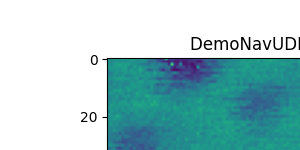

<IPython.core.display.Javascript object>


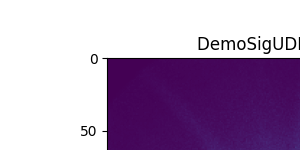

In [18]:
live_plots = [
    MPLLive2DPlot(dataset=ds, udf=udfs[0], channel=nav_ratio),
    MPLLive2DPlot(dataset=ds, udf=udfs[1], channel=sig_ratio),
]

for p in live_plots:
    p.display()
    p.fig.colorbar(p.im_obj)

In [19]:
res = ctx.run_udf(dataset=ds, udf=udfs, plots=live_plots)

### Region of interest (ROI)

The shape of result buffers can depend on the ROI in some cases. The most notable example is `libertem.udf.raw.PickUDF`. For that reason we should pass the ROI to the constructor of `Live2DPlot` subclasses if the UDFs will be run with a ROI.

In [20]:
roi = np.zeros(ds.shape.nav, dtype=bool)
roi[0,0] = True
pick_udf = PickUDF()

<IPython.core.display.Javascript object>


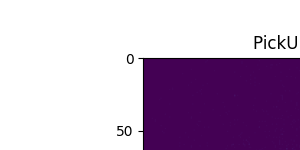

{'intensity': <BufferWrapper kind=single dtype=uint8 extra_shape=(1, 256, 256)>}

In [21]:
# This just works, the ROI is handled correctly internally
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=True)

<IPython.core.display.Javascript object>


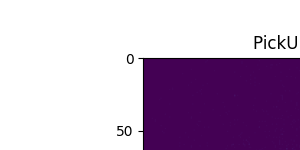

In [22]:
# Here we have to pass the ROI
# If this was omitted, the PickUDF would allocate memory for the entire dataset and the plot would try to display that!
live_plot_pick = MPLLive2DPlot(dataset=ds, udf=pick_udf, roi=roi, channel='intensity')
live_plot_pick.display()

In [23]:
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=[live_plot_pick])

{'intensity': <BufferWrapper kind=single dtype=uint8 extra_shape=(1, 256, 256)>}

Note that the first axis of the result of `PickUDF` matches the number of entries in the ROI that are `True`. If this is a single one, this axis is "squeezed out" with default plotting. If functions are used to transform the result, this is the responsibility of the user. If more than one entry in the ROI is `True`, the result can't be plotted with default methods since it can't be squeezed to 2D anymore.

<IPython.core.display.Javascript object>


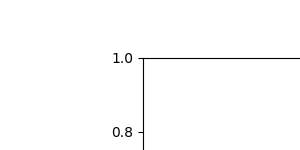

TypeError: Invalid shape (1, 256, 256) for image data

In [24]:
# NBVAL_RAISES_EXCEPTION
# Error, wrong shape!
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=[[('intensity', lambda x: x)]])

<IPython.core.display.Javascript object>


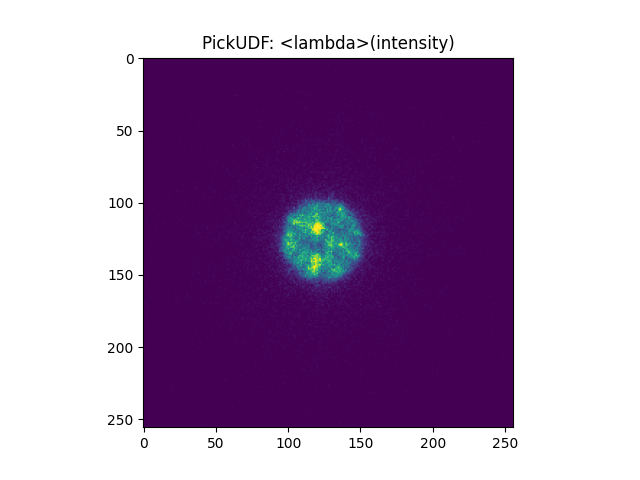

{'intensity': <BufferWrapper kind=single dtype=uint8 extra_shape=(1, 256, 256)>}

In [25]:
# Works, we squeeze the extra axis out
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=[[('intensity', lambda x: x.squeeze())]])

In [26]:
# We have a ROI with two entries
roi[0, 0] = True
roi[-1, -1] = True

In [27]:
# No plot shown since the result is 3D now
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=True)

/home/alex/source/LiberTEM/src/libertem/api.py:863: UserWarning: No plottable channels found for UDF #0: PickUDF, not plotting.
  warnings.warn(


{'intensity': <BufferWrapper kind=single dtype=uint8 extra_shape=(2, 256, 256)>}